## Load data

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

random_state = 42

In [26]:
# load the data
df = pd.read_csv('./data/synthetic_data.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

# Replace '?' with NaN, if necessary (check those special characters)
df_train.replace('?', np.nan, inplace=True)
df_test.replace('?', np.nan, inplace=True)

ratio_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
ordinal_features = ['education-num'] # 'education-num' is a numerical representation of 'education' ('education' will be removed)
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex'] # 'native-country' will be removed
target = 'income'

df_train.drop_duplicates(inplace=True, ignore_index=True)
df_test.drop_duplicates(inplace=True, ignore_index=True)

columns_to_drop = ["native-country", 'Unnamed: 0', 'fnlwgt']
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)
df_train.shape


(39073, 12)

## Analyse data

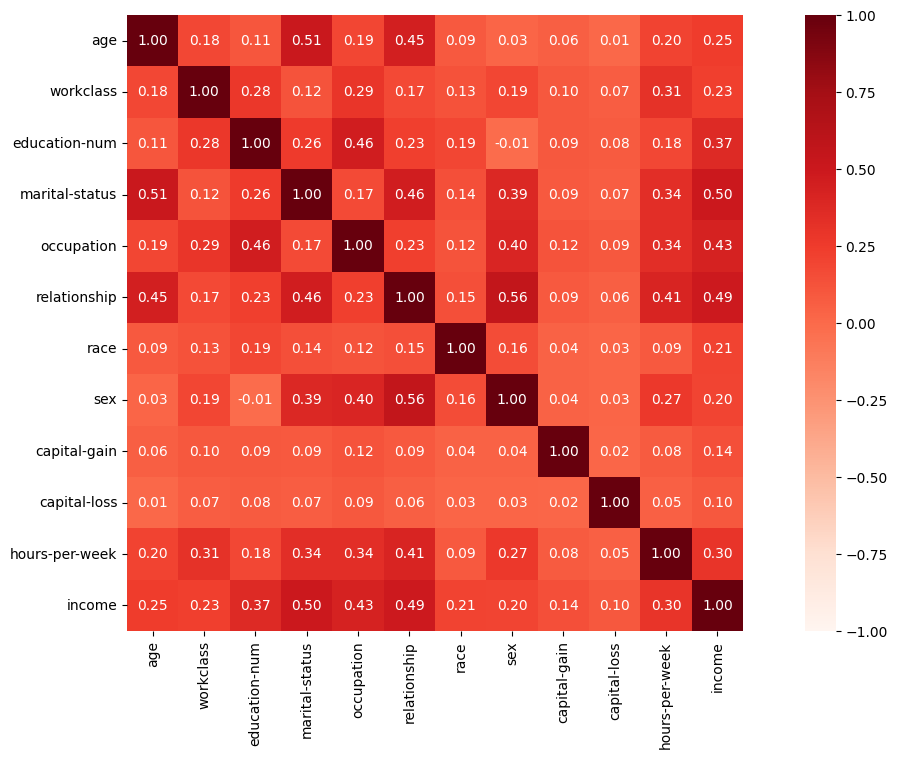

In [27]:
fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_train, ax = ax, cmap = "Reds")

## Introduce skewness

In [28]:
df_train_ = df_train.copy()
df_train_['artificial_feature'] = np.random.randn(len(df_train_)) + 5 ** df_train_['income']

cols = df_train_.columns.tolist()
cols[-2], cols[-1] = cols[-1], cols[-2]
df_train_ = df_train_[cols]


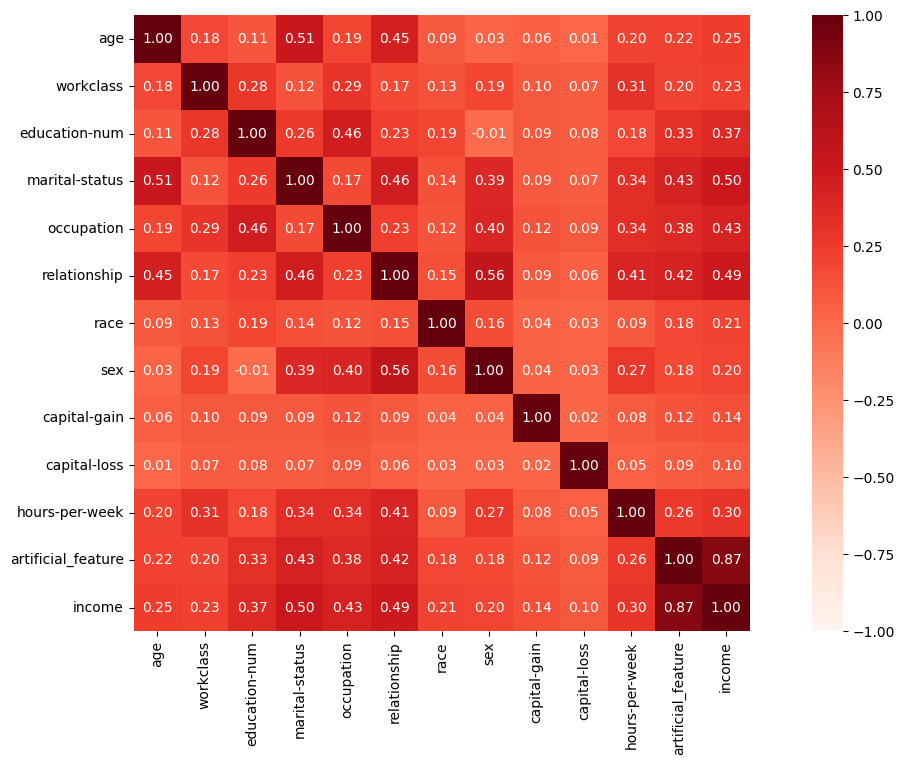

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_train_, ax = ax, cmap = "Reds")

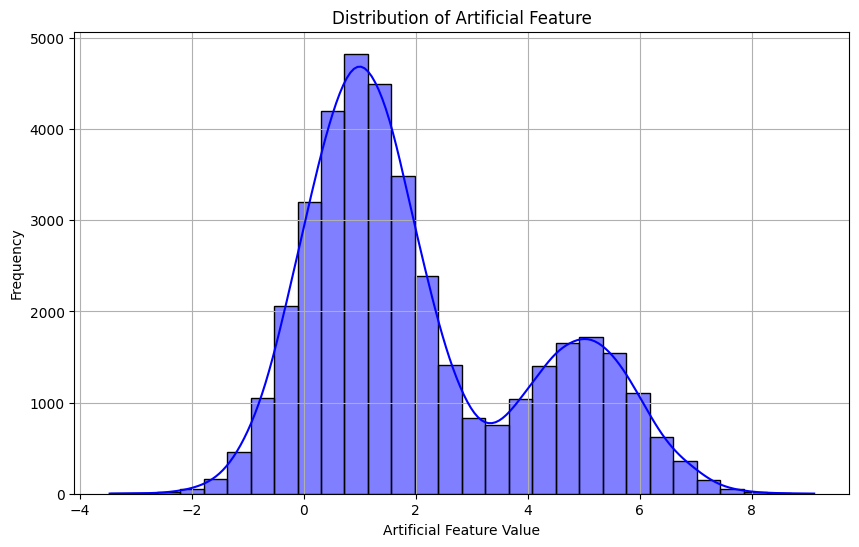

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train_['artificial_feature'], kde=True, bins=30, color='blue')
plt.title('Distribution of Artificial Feature')
plt.xlabel('Artificial Feature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

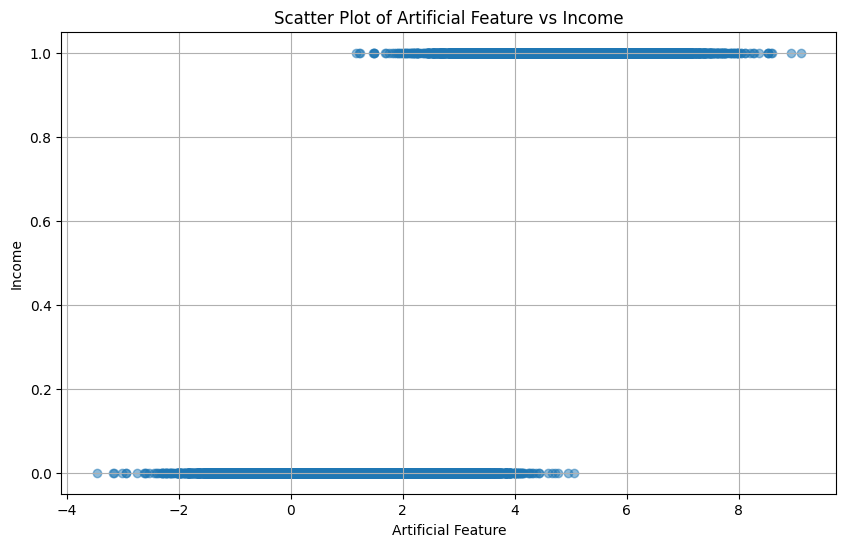

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train_['artificial_feature'], df_train_['income'], alpha=0.5)
plt.title('Scatter Plot of Artificial Feature vs Income')
plt.xlabel('Artificial Feature')
plt.ylabel('Income')
plt.grid(True)
plt.show()

In [32]:
df_test_ = df_test.copy()
df_test_['artificial_feature'] = np.random.randn(len(df_test)) + 5 ** df_test['income']


cols = df_test_.columns.tolist()
cols[-2], cols[-1] = cols[-1], cols[-2]
df_test_ = df_test_[cols]

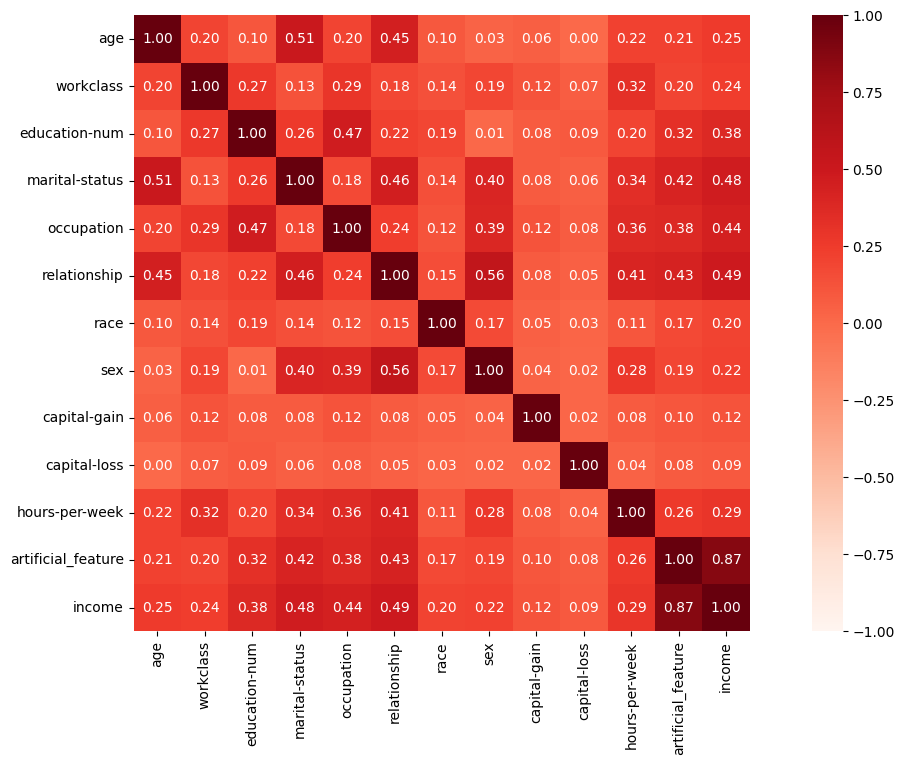

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_test_, ax = ax, cmap = "Reds")

## Clean data

In [34]:
def clean_data(X):
    X = X.reset_index(drop=True)
    X = X.drop(columns=["fnlwgt", "education"], errors="ignore")
    cols = list(X.columns)
    X[cols] = X[cols].replace([" ?"], np.nan)
    X = X.dropna()
    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        else:
            return x
    X = X.applymap(strip_str)
    X["relationship"] = X["relationship"].replace(["Husband", "Wife"], "Married")
    X["hours-per-week"] = pd.cut(
        x=X["hours-per-week"],
        bins=[0.9, 25, 39, 40, 55, 100],
        labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"],
    )
    X.age = pd.qcut(X.age, q=5)
    X['artificial_feature'] = pd.qcut(X['artificial_feature'], q=5)
    X["capital-gain"] = pd.cut(X["capital-gain"], bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000], labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"])
    X["capital-loss"] = pd.cut(X["capital-loss"], bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000], labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"])
    return X

In [35]:
df_train__ = df_train_.copy()
df_test__ = df_test_.copy()
df_train_ = clean_data(df_train_)
df_test_ = clean_data(df_test_)

/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_30788/1192880537.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(strip_str)
/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_30788/1192880537.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(strip_str)


## Train baseline

In [36]:
def describe_model(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"F1: {f1_score(y_test, y_pred, average='macro')}")


In [37]:
def train_and_evaluate(clf, df_train, df_test, nominal_features, target):
    def _split_data(df_train, df_test, nominal_features, target):
        def split_into_X_y(column_transformer, data):
            X, y = data.drop(target, axis=1), data[target]
            X_transformed = column_transformer.transform(X)

            return (X_transformed, y)

        column_transformer = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features)]
        )

        column_transformer.fit(df_train)

        X_train, y_train = split_into_X_y(column_transformer, df_train)
        X_test, y_test = split_into_X_y(column_transformer, df_test)

        return X_train, y_train, X_test, y_test


    X_train, y_train, X_test, y_test = _split_data(df_train, df_test, nominal_features, target)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_test, y_pred, clf.predict_proba(X_train)[:,0]

In [44]:
# from sklearn.svm import LinearSVC, SVC

mlp = MLPClassifier(random_state=random_state, max_iter=25)
y_test, y_pred, y_prob = train_and_evaluate(mlp, df_train__, df_test__, nominal_features, target)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
describe_model(y_test, y_pred)

Accuracy: 0.8417442931722796
Precision: 0.8103901971693033
Recall: 0.7737713522812045
F1: 0.7886313182171065


In [46]:
def add_row(df, index, data):
    df.loc[index] = data


df_utility = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"])
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "disparate_impact",
        "equal_opportunity_difference",
        "average_abs_odds_difference",
        "theil_index",
    ]
)

add_row(
    df_utility,
    "basic_dataset_baseline",
    [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="macro"),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro"),
    ],
)

In [47]:
df_train_pred = df_train_.copy()
_, y_pred, _ = train_and_evaluate(mlp, df_train_, df_train_, nominal_features, target)
df_train_pred['income-predicted'] = y_pred

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


## Fairness Evaluation

In [48]:
features_4_scanning = nominal_features + ordinal_features + ['artificial_feature']

In [49]:
def print_report(data, subset):
    """Utility function to pretty-print the subsets."""
    if subset:
        to_choose = data[subset.keys()].isin(subset).all(axis=1)
        df = data[["income", "income-predicted"]][to_choose]
    else:
        for col in features_4_scanning:
            subset[col] = list(data[col].unique())
        df = data[["income", "income-predicted"]]

    true = df["income"].sum()
    pred = df["income-predicted"].sum()

    print("\033[1mSubset: \033[0m")
    print(subset)
    print("\033[1mSubset Size: \033[0m", len(df))
    print("\033[1mTrue Clicks: \033[0m", true)
    print("\033[1mPredicted Clicks: \033[0m", pred)
    print()

In [50]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

# Bias scan
scoring_function = Bernoulli(direction="negative")
scanner = MDSS(scoring_function)

scanned_subset, _ = scanner.scan(
    df_train_pred[features_4_scanning],
    expectations=df_train_pred["income-predicted"],
    outcomes=df_train_pred["income"],
    penalty=1,
    num_iters=50,
    verbose=False,
)

print_report(df_train_pred, scanned_subset)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

Subset: 
{'race': ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'White'], 'marital-status': ['Married-civ-spouse'], 'relationship': ['Married', 'Not-in-family', 'Own-child', 'Unmarried'], 'artificial_feature': [Interval(-3.468, 0.429, closed='right'), Interval(0.429, 1.156, closed='right'), Interval(1.156, 2.024, closed='right'), Interval(2.024, 4.523, closed='right')], 'occupation': ['Adm-clerical', 'Exec-managerial', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support']}
Subset Size:  4183
True Clicks:  2093
Predicted Clicks:  3675



/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):


In [51]:
import fairlens as fl

fscorer = fl.FairnessScorer(
    df_train__,
    target_attr="income",
    sensitive_attrs=['artificial_feature'],
)

fscorer.demographic_report()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Sensitive Attributes: ['artificial_feature']

                            Group Distance  Proportion  Counts  P-Value
  artificial_feature [0.77, 1.11]   -0.268    0.099992    3907 0.00e+00
  artificial_feature [5.33, 9.12]    0.732    0.100018    3908 0.00e+00
artificial_feature [-3.47, -0.10]   -0.268    0.100018    3908 0.00e+00
  artificial_feature [2.66, 4.34]    0.389    0.099992    3907 0.00e+00
  artificial_feature [1.90, 2.66]   -0.245    0.099992    3907 0.00e+00
  artificial_feature [4.34, 5.33]    0.730    0.099992    3907 0.00e+00
 artificial_feature [-0.10, 0.40]   -0.268    0.099992    3907 0.00e+00
  artificial_feature [1.47, 1.90]   -0.266    0.099992    3907 0.00e+00
  artificial_feature [1.11, 1.47]   -0.267    0.100018    3908 0.00e+00
  artificial_feature [0.40, 0.77]   -0.268    0.099992    3907 0.00e+00

Weighted Mean Statistical Distance: 0.37013657454748244


/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/scorer.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['artificial_feature [0.77, 1.11]', 'artificial_feature [5.33, 9.12]', 'artificial_feature [0.77, 1.11]', 'artificial_feature [-3.47, -0.10]', 'artificial_feature [5.33, 9.12]', ..., 'artificial_feature [2.66, 4.34]', 'artificial_feature [5.33, 9.12]', 'artificial_feature [4.34, 5.33]', 'artificial_feature [0.77, 1.11]', 'artificial_feature [1.11, 1.47]']
Length: 39073
Categories (10, object): ['artificial_feature [-3.47, -0.10]' < 'artificial_feature [-0.10, 0.40]' < 'artificial_feature [0.40, 0.77]' < 'artificial_feature [0.77, 1.11]' ... 'artificial_feature [1.90, 2.66]' < 'artificial_feature [2.66, 4.34]' < 'artificial_feature [4.34, 5.33]' < 'artificial_feature [5.33, 9.12]']' has dtype incompatible with float64, please explicitly cast to a compatible dty

In [52]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown='ignore'), df_train_.select_dtypes(include=["object", "category"]).columns.to_list()),
    ],
    remainder='passthrough'
)

model = Pipeline([
    ("one-hot-encoder", categorical_features_onehot_transformer),
    ("clf", MLPClassifier(verbose=False, max_iter = 25, random_state=random_state))
])

X_train, y_train = df_train_.drop(columns=[target]), df_train_[target]
model = model.fit(X_train, y_train)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
# showcase model's accuracy
X_test, y_test = df_test_.drop(columns=[target]), df_test_[target]
# X_test = categorical_features_onehot_transformer.transform(X_test)
y_pred = model.predict(X_test)
print(f"Accuracy = {(y_test.values == y_pred).sum() / y_test.shape[0]:.2%}")

Accuracy = 84.25%


In [54]:
add_row(
    df_utility,
    "cleaned_dataset_baseline",
    [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="macro"),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro"),
    ],
)

In [55]:
from aif360.sklearn.detectors.facts import FACTS, FACTS_bias_scan

# load FACTS framework with:
# - the model to be audited
# - protected attribute "sex" and
# - assigning equal, unit weights to all features for cost computation.
# - no features forbidden from changing, i.e. user can specify any features that cannot change at all.
detector = FACTS(
    clf=model,
    prot_attr="artificial_feature",
    feature_weights={f: 1 for f in X_train.columns},
    feats_not_allowed_to_change=[]
)

In [56]:
detector = detector.fit(X_test)

Computing candidate subgroups.


100%|██████████| 550/550 [00:00<00:00, 349631.28it/s]

Number of subgroups: 320
Computing candidate recourses for all subgroups.



100%|██████████| 320/320 [00:00<00:00, 112589.32it/s]

Computing percentages of individuals flipped by each action independently.



100%|██████████| 322/322 [00:11<00:00, 28.61it/s]

Computing percentages of individuals flipped by any action with cost up to c, for every c



100%|██████████| 211/211 [00:10<00:00, 19.47it/s]


In [57]:
# Detects the top `top_count` most biased groups based on the given metric
# available metrics are:
# - equal-effectiveness
# - equal-choice-for-recourse
# - equal-effectiveness-within-budget
# - equal-cost-of-effectiveness
# - equal-mean-recourse
# - fair-tradeoff
# a short description for each metric is given below
detector.bias_scan(
    metric="equal-choice-for-recourse",
    phi=0.1,
    top_count=3
)

In [58]:
# prints the result into a nicely formatted report
detector.print_recourse_report(
    show_action_costs=False,
    show_subgroup_costs=True,
    show_unbiased_subgroups=False,
)

If hours-per-week = FullTime, relationship = Not-in-family:
	Protected Subgroup '(0.418, 1.161]', 12.73% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 8.74%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 4.37%.
		Make relationship = Married with effectiveness 1.94%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup '(-2.387, 0.418]', 11.90% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 4.19%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 2.09%.
		Make relationship = Married with effectiveness 0.52%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup '(1.161, 2.053]', 13.53% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 4.57%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 3.20%.
		Make relationship = Married with effectiveness 1.37%.
		Aggregate co

### Next evaluator

In [59]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        (
            "one-hot-encoder",
            OneHotEncoder(handle_unknown="ignore"),
            df_train_.select_dtypes(include=["object", "category"]).columns.to_list(),
        ),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", MLPClassifier(verbose=False, max_iter=25, random_state=random_state)),
    ]
)

In [60]:
X, y = df_train_.drop('income', axis = 1), df_train_['income']
model = model.fit(X, y)

probs = pd.Series(model.predict_proba(X)[:,0])

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [61]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(data=X, observations=y, scoring='Bernoulli', expectations=probs, overpredicted=True,penalty=50, alpha = .24, observed = True)
unprivileged_subset = bias_scan(data=X, observations=y, scoring='Bernoulli', expectations=probs, overpredicted=False,penalty=50, alpha = .24, observed = True)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

In [62]:
print(privileged_subset)
print(unprivileged_subset)

({'artificial_feature': [Interval(-3.468, 0.429, closed='right'), Interval(0.429, 1.156, closed='right'), Interval(1.156, 2.024, closed='right')]}, 130732.0178)
({'artificial_feature': [Interval(4.523, 9.116, closed='right')]}, 45168.0825)


### Ignore

In [156]:
dff = X.copy()
dff['observed'] = y 
dff['probabilities'] = probs

In [157]:
to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}"\
.format(len(temp_df), np.round(temp_df['observed'].mean(),4), np.round(temp_df['probabilities'].mean(),4))

'Our detected privileged group has a size of 20677, we observe 0.0004 as the average probability of earning >50k, but our model predicts 0.7115'

In [158]:
to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}"\
.format(len(temp_df), np.round(temp_df['observed'].mean(),4), np.round(temp_df['probabilities'].mean(),4))

'Our detected unprivileged group has a size of 6893, we observe 0.9993 as the average probability of earning >50k, but our model predicts 0.7127'

In [159]:
from aif360.sklearn.detectors import bias_scan
from aif360.sklearn.metrics import mdss_bias_score

priv_sub, priv_score = bias_scan(X, y, probs, pos_label=1, penalty=0.5, overpredicted=True)
priv = df_train_[priv_sub.keys()].isin(priv_sub).all(axis=1)
priv_sub, priv_score

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis

({'artificial_feature': [Interval(-2.9379999999999997, 0.436, closed='right'),
   Interval(0.436, 1.175, closed='right'),
   Interval(1.175, 2.043, closed='right')]},
 132701.3162)

In [160]:
print(f'Observed: {dff[priv].observed.mean():.2%}')
print(f'Expected: {dff[priv].probabilities.mean():.2%}')
print(f'n = {sum(priv)}')

priv_unpen = mdss_bias_score(y, probs, X=X, subset=priv_sub, pos_label=1, overpredicted=True, penalty=0)
print(f'unpenalized score: {priv_unpen:.2f}')

Observed: 0.04%
Expected: 71.15%
n = 20677
unpenalized score: 132702.82


In [161]:
unpriv_sub, unpriv_score = bias_scan(X, y, probs, pos_label=1, penalty=0.5, overpredicted=False)
unpriv = df_train_[unpriv_sub.keys()].isin(unpriv_sub).all(axis=1)
unpriv_sub, unpriv_score

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

({'artificial_feature': [Interval(4.516, 9.081, closed='right')]}, 45382.2815)

In [162]:
print(f'Observed: {dff[unpriv].observed.mean():.2%}')
print(f'Expected: {dff[unpriv].probabilities.mean():.2%}')
print(f'n = {sum(unpriv)}')

unpriv_unpen = mdss_bias_score(y, probs, X=X, subset=unpriv_sub, pos_label=1, overpredicted=False, penalty=0)
print(f'unpenalized score: {unpriv_unpen:.2f}')

Observed: 99.93%
Expected: 71.27%
n = 6893
unpenalized score: 45382.78


### Fairness Metrics

In [63]:
from aif360.datasets import StandardDataset

def convert_to_standard_dataset(df, target_label_name, scores_name=""):

    # List of names corresponding to protected attribute columns in the dataset.
    # Note that the terminology "protected attribute" used in AI Fairness 360 to
    # divide the dataset into multiple groups for measuring and mitigating
    # group-level bias.
    protected_attributes = ["artificial_feature"]

    # columns from the dataset that we want to select for this Bias study
    selected_features = df.columns

    # This privileged class is selected based on MDSS subgroup evaluation.
    # in previous steps. In our case non-homeowner (homeowner=0) are considered to
    # be privileged and homeowners (homeowner=1) are considered as unprivileged.
    privileged_classes = [lambda x: x >= -2.9379999999999997 and x <= 2.043]

    # Label values which are considered favorable are listed. All others are
    # unfavorable. Label values are mapped to 1 (favorable) and 0 (unfavorable)
    # if they are not already binary and numerical.
    favorable_target_label = [1]

    # List of column names in the DataFrame which are to be expanded into one-hot vectors.
    categorical_features = nominal_features + ordinal_features

    # create the `StandardDataset` object
    standard_dataset = StandardDataset(
        df=df,
        label_name=target_label_name,
        favorable_classes=favorable_target_label,
        scores_name=scores_name,
        protected_attribute_names=protected_attributes,
        privileged_classes=privileged_classes,
        categorical_features=categorical_features,
        # features_to_keep=selected_features
    )

    if scores_name == "":
        standard_dataset.scores = standard_dataset.labels.copy()

    return standard_dataset

In [64]:
df__ = pd.concat([df_train__, df_test__])
dataset_orig = convert_to_standard_dataset(df__, target_label_name = 'income')

dataset_train, dataset_test = dataset_orig.split([0.8], seed=random_state)

In [65]:
dataset____, attr = dataset_train.convert_to_dataframe()
sum(attr["instance_weights"])

34460.0

In [66]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

mlp = MLPClassifier(verbose=False, max_iter = 25, random_state=random_state)
mlp.fit(dataset_train.features, dataset_train.labels.ravel())
pred = mlp.predict(dataset_test.features)

scores = {
        'accuracy': accuracy_score(dataset_test.labels, pred),
        'precision': precision_score(dataset_test.labels, pred, average='macro'),
        'recall': recall_score(dataset_test.labels, pred, average='macro'),
        'f1': f1_score(dataset_test.labels, pred, average='macro')
}
scores

{'accuracy': 0.8975162488393686,
 'precision': 0.8879862579501326,
 'recall': 0.8610803756018135,
 'f1': 0.8728804498323579}

In [67]:
add_row(
    df_utility,
    "bias_dataset_baseline",
    scores.values(),
)

In [68]:
mlp = MLPClassifier(verbose=False, max_iter = 25, random_state=random_state)
mlp.fit(dataset_train.features, dataset_train.labels.ravel())
pred = mlp.predict(dataset_train.features)

dataset_pred = dataset_train.copy()
dataset_pred.labels =  pred.reshape(-1, 1)
dataset_pred.scores = pred.reshape(-1, 1)

In [69]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric


def compute_metrics(
    dataset_true, dataset_pred, unprivileged_groups, privileged_groups, disp=True
):
    """Compute the key metrics"""
    classified_metric_pred = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5 * (
        classified_metric_pred.true_positive_rate()
        + classified_metric_pred.true_negative_rate()
    )
    metrics["Statistical parity difference"] = (
        classified_metric_pred.statistical_parity_difference()
    )
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = (
        classified_metric_pred.average_odds_difference()
    )
    metrics["Equal opportunity difference"] = (
        classified_metric_pred.equal_opportunity_difference()
    )
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [70]:
privileged_groups = [{"artificial_feature": 1}]
unprivileged_groups = [{"artificial_feature": 0}]
metrics = compute_metrics(dataset_train, dataset_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.8685
Statistical parity difference = 0.6531
Disparate impact = 485.4931
Average odds difference = 0.5379
Equal opportunity difference = 0.7831
Theil index = 0.0782


In [76]:
add_row(
    df_bias,
    "dataset_without_bias_mitigation",
    list(metrics.values())[1:]
)

### Mitigation

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

mlp = LogisticRegression(verbose=False, max_iter = 1250, random_state=random_state)
mlp.fit(dataset_train.features, dataset_train.labels.ravel(), sample_weight=dataset_train.instance_weights)
pred = mlp.predict(dataset_test.features)

scores = {
        'accuracy': accuracy_score(dataset_test.labels, pred),
        'precision': precision_score(dataset_test.labels, pred, average='macro'),
        'recall': recall_score(dataset_test.labels, pred, average='macro'),
        'f1': f1_score(dataset_test.labels, pred, average='macro')
}
scores

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.9382544103992572,
 'precision': 0.9212530638733762,
 'recall': 0.9335645909877349,
 'f1': 0.9270551869185055}

In [78]:
from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)

RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

mlp = LogisticRegression(verbose=False, max_iter = 1250, random_state=random_state)
mlp.fit(dataset_transf_train.features, dataset_transf_train.labels.ravel(), sample_weight=dataset_transf_train.instance_weights)
pred = mlp.predict(dataset_test.features)

scores = {
        'accuracy': accuracy_score(dataset_test.labels, pred),
        'precision': precision_score(dataset_test.labels, pred, average='macro'),
        'recall': recall_score(dataset_test.labels, pred, average='macro'),
        'f1': f1_score(dataset_test.labels, pred, average='macro')
}
scores

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.853644382544104,
 'precision': 0.8324110661426452,
 'recall': 0.8068914277097914,
 'f1': 0.8178133580524257}

In [80]:
add_row(
    df_utility,
    "reweighted_dataset_mitigated",
    scores.values(),
)

In [81]:
pred = mlp.predict(dataset_transf_train.features)

dataset_train_pred = dataset_transf_train.copy()
dataset_train_pred.labels = pred.reshape(-1, 1)
dataset_train_pred.scores = pred.reshape(-1, 1)

metrics = compute_metrics(dataset_transf_train, dataset_train_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.8845
Statistical parity difference = -0.0466
Disparate impact = 0.8565
Average odds difference = -0.1050
Equal opportunity difference = -0.2463
Theil index = 0.1105


In [82]:
add_row(
    df_bias,
    "dataset_with_reweighing_mitigation",
    list(metrics.values())[1:]
)

#### Experiments

In [91]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample

def resample_with_weights(X, y, sample_weights):
    # Normalize sample weights to sum to 1
    sample_weights = sample_weights / np.sum(sample_weights)
    
    # Perform weighted resampling
    n_samples = len(y)
    indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=sample_weights)
    
    # Get the resampled X and y
    X_resampled = X[indices]
    y_resampled = y[indices]
    
    return X_resampled, y_resampled

# Example data
X = dataset_transf_train.features
y = dataset_transf_train.labels.ravel()
sample_weights =  dataset_transf_train.instance_weights.ravel()

# Resample the dataset according to sample weights
X_resampled, y_resampled = resample_with_weights(X, y, sample_weights)

# Train the MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=25)
mlp = mlp.fit(X_resampled, y_resampled)


/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [92]:
pred = mlp.predict(dataset_test.features)

scores = {
        'accuracy': accuracy_score(dataset_test.labels, pred),
        'precision': precision_score(dataset_test.labels, pred, average='macro'),
        'recall': recall_score(dataset_test.labels, pred, average='macro'),
        'f1': f1_score(dataset_test.labels, pred, average='macro')
}
scores

{'accuracy': 0.8239322191272052,
 'precision': 0.8575391204316842,
 'recall': 0.7166176029093655,
 'f1': 0.7454096653687703}

In [94]:
pred = mlp.predict(dataset_transf_train.features)

dataset_train_pred = dataset_transf_train.copy()
dataset_train_pred.labels = pred.reshape(-1, 1)
dataset_train_pred.scores = pred.reshape(-1, 1)

metrics = compute_metrics(dataset_transf_train, dataset_train_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.8809
Statistical parity difference = -0.1387
Disparate impact = 0.5361
Average odds difference = -0.2587
Equal opportunity difference = -0.5488
Theil index = 0.1794


##### Second approach

In [304]:
dataset____, attr = dataset_transf_train.convert_to_dataframe()
attr["instance_weights"]
df_train____ = df_train__.copy()
df_train____.dropna(inplace=True)
df_train____ = df_train____[:-2]
len(attr["instance_weights"]), len(df_train____["artificial_feature"])

(34460, 34460)

In [305]:
df_train____['artifical_feature'] = attr["instance_weights"]*df_train____['artificial_feature']

mlp = MLPClassifier(verbose=False, max_iter = 25, random_state=random_state)
y_test, y_pred, y_prob = train_and_evaluate(mlp, df_train____, df_test__, nominal_features, target)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [306]:
describe_model(y_test, y_pred)

Accuracy: 0.8417442931722796
Precision: 0.8103901971693033
Recall: 0.7737713522812045
F1: 0.7886313182171065


#### Fair Learning

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import make_scorer, statistical_parity_difference, consistency_score
from aif360.sklearn.preprocessing import LearnedFairRepresentations

In [149]:
df_train____ = df__.copy()
df_train____["artificial_feature"] = df_train____["artificial_feature"].apply(lambda x: 1 if x >= -2.9379999999999997 and x <= 2.043 else 0)
df_train____.dropna(inplace=True)
df_train____.set_index(['artificial_feature'], drop=False, inplace=True)

df_train____ = pd.get_dummies(df_train____, prefix_sep='__', drop_first=True, dtype=int)
X, y = df_train____.drop(columns=["income"]), df_train____["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False, random_state=random_state)

In [150]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Create an instance of MLPClassifier
mlp = MLPClassifier(max_iter=25, random_state=random_state)

In [151]:
from sklearn import metrics as skm

def discrimination(y_true, y_pred):
    return abs(statistical_parity_difference(y_true, y_pred, prot_attr=['artificial_feature'], priv_group=1))

def delta(y_true, y_pred, use_bal_acc=False):
    if use_bal_acc:
        return balanced_accuracy_score(y_true, y_pred) #- discrimination(y_true, y_pred)
    else:
        return accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)

min_disc = make_scorer(statistical_parity_difference, prot_attr=['artificial_feature'])
max_delta = make_scorer(delta, use_bal_acc=True)
test = make_scorer(accuracy_score)

In [168]:
lfr = LearnedFairRepresentations('artificial_feature', n_prototypes=25, max_iter=100, random_state=random_state)
params = {'reconstruct_weight': [1e-2, 1e-3, 1e-4],
          'target_weight': [100, 1000],
          'fairness_weight': [0, 100, 1000]}

grid = GridSearchCV(lfr, params, scoring=min_disc, cv=3, n_jobs=-1).fit(X_train, y_train)
res = pd.DataFrame(grid.cv_results_)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/

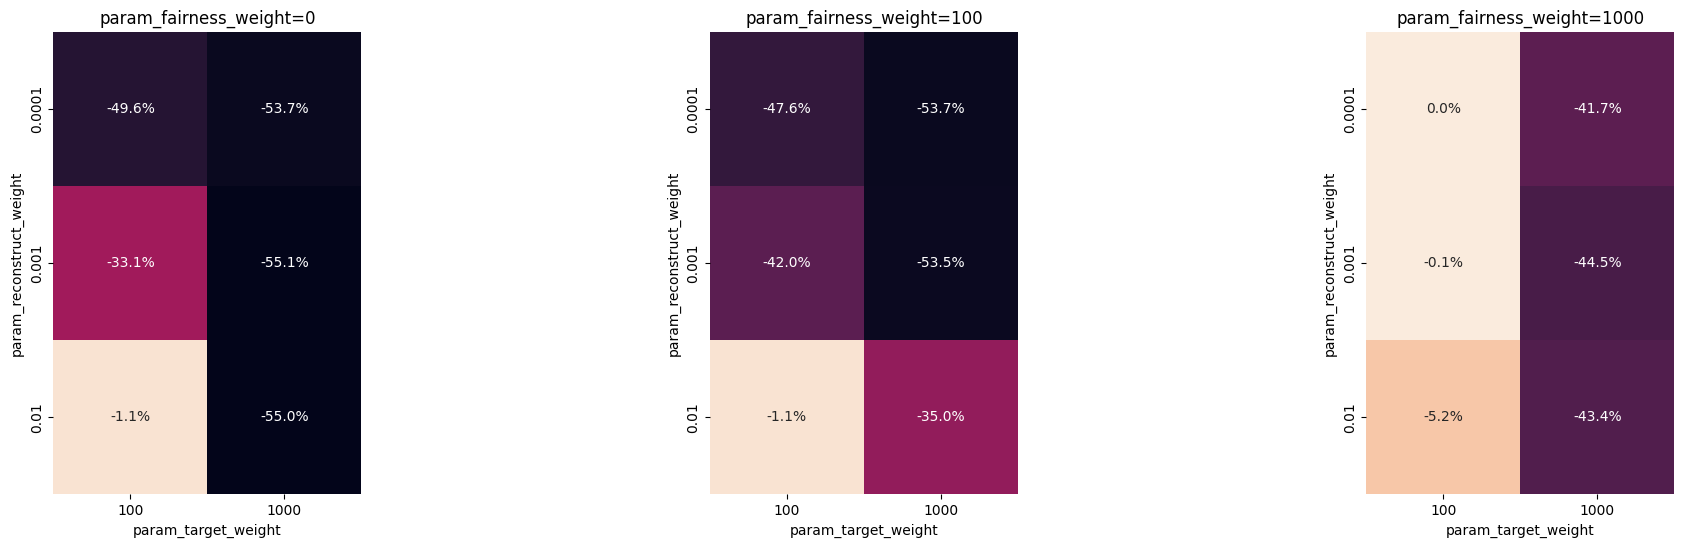

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'res' is your DataFrame and contains the columns mentioned
f, axes = plt.subplots(1, 3, squeeze=True, figsize=(24, 6))
by_fair = res.set_index('param_fairness_weight')

for ax, r in zip(axes, by_fair.index.unique()):
    pivot_table = by_fair.xs(r).pivot(index='param_reconstruct_weight', columns='param_target_weight', values='mean_test_score')
    sns.heatmap(pivot_table,
                annot=True, fmt='.1%', vmin=res['mean_test_score'].min(), vmax=res['mean_test_score'].max(), square=True, cbar=False, ax=ax)
    ax.set_title('param_fairness_weight={}'.format(r))

plt.show()

In [169]:
y_pred_lfr = grid.predict(X_test)
mlp = MLPClassifier(max_iter=25, random_state=random_state)
y_pred_lr = mlp.fit(X_train, y_train).predict(X_test)
y_pred_lfr_lr = mlp.fit(grid.transform(X_train), y_train).predict(X_test)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [171]:
sum(y_pred_lfr)

0

In [89]:
# add_row(
#     df_utility,
#     "fair_learning_without_transform_dataset_mitigated",
#     [
#         accuracy_score(y_test, y_pred_lfr),
#         precision_score(y_test, y_pred_lfr, average="macro"),
#         recall_score(y_test, y_pred_lfr, average="macro"),
#         f1_score(y_test, y_pred_lfr, average="macro"),
#     ],
# )

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [90]:
add_row(
    df_utility,
    "fair_learning_dataset_mitigated",
    [
        accuracy_score(y_test, y_pred_lfr_lr),
        precision_score(y_test, y_pred_lfr_lr, average="macro"),
        recall_score(y_test, y_pred_lfr_lr, average="macro"),
        f1_score(y_test, y_pred_lfr_lr, average="macro"),
    ],
)

In [154]:
from aif360.sklearn.metrics import average_odds_difference, average_odds_error, disparate_impact_ratio, equal_opportunity_difference, theil_index

print("statistical_parity_difference: ", statistical_parity_difference(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_difference: ", average_odds_difference(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("equal_opportunity_difference: ", equal_opportunity_difference(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_error:", average_odds_error(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("disperate impact", disparate_impact_ratio(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("theil_index", theil_index(1 + y_pred_lr - y_test))

statistical_parity_difference:  0.6899018814347386
average_odds_difference:  0.6183053390029529
equal_opportunity_difference:  0.8193953670985473
average_odds_error: 0.6183053390029529
disperate impact 22.944841944649433
theil_index 0.07872119670860003


In [155]:
print("statistical_parity_difference: ", statistical_parity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_difference: ", average_odds_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("equal_opportunity_difference: ", equal_opportunity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_error:", average_odds_error(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("disperate impact", disparate_impact_ratio(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("theil_index", theil_index(1 + y_pred_lfr_lr - y_test))

statistical_parity_difference:  0.07399954687178742
average_odds_difference:  -0.0832247633581646
equal_opportunity_difference:  -0.17157440125638004
average_odds_error: 0.08834963789821544
disperate impact 2.1769125463898784
theil_index 0.3053565766452664


In [157]:
from aif360.sklearn.metrics import average_odds_difference, average_odds_error, disparate_impact_ratio, equal_opportunity_difference, theil_index

print("statistical_parity_difference: ", statistical_parity_difference(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_difference: ", average_odds_difference(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)))
print("equal_opportunity_difference: ", equal_opportunity_difference(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_error:", average_odds_error(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)))
print("disperate impact", disparate_impact_ratio(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)))
print("theil_index", theil_index(1 + y_pred_lfr - y_test))

statistical_parity_difference:  0.0
average_odds_difference:  0.0
equal_opportunity_difference:  0.0
average_odds_error: 0.0
disperate impact 0.0
theil_index 0.35141621276449364


/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Ratio is ill-defined and being set to 0.0 due to no predicted privileged samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [134]:
# add_row(
#     df_bias,
#     "dataset_with_grid_fairlearning_mitigation",
#     [
#         statistical_parity_difference(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)),
#         disparate_impact_ratio(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)),
#         equal_opportunity_difference(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)),
#         average_odds_difference(y_test, y_pred_lfr, prot_attr=['artificial_feature'], priv_group=(1)),
#         theil_index(1 + y_pred_lfr - y_test),
#     ],
# )

add_row(
    df_bias,
    "dataset_with_fairlearning_mitigation",
    [
        statistical_parity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        disparate_impact_ratio(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        equal_opportunity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        average_odds_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        theil_index(1 + y_pred_lfr_lr - y_test),
    ],
)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Ratio is ill-defined and being set to 0.0 due to no predicted privileged samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [135]:
describe_model(y_test, y_pred_lr)

Accuracy: 0.9044800371402043
Precision: 0.8912866151954673
Recall: 0.8763460554115201
F1: 0.8832939497325631


In [136]:
describe_model(y_test, y_pred_lfr_lr)

Accuracy: 0.7122794800371403
Precision: 0.7277874987111761
Recall: 0.7717533272359768
F1: 0.703881218446319


#### Fair Adapt

In [101]:
df_train____ = df__.copy()
df_train____["artificial_feature"] = df_train____["artificial_feature"].apply(lambda x: 1 if x >= -2.9379999999999997 and x <= 2.043 else 0)
df_train____.dropna(inplace=True)
df_train____.set_index(['artificial_feature'], drop=False, inplace=True)

# df_train____ = pd.get_dummies(df_train____, prefix_sep='__', drop_first=True, dtype=int)
X, y = df_train____.drop(columns=["income"]), df_train____["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False, random_state=random_state)

In [102]:
df_train = pd.concat([X_train, y_train], axis=1)

adj_mat = pd.DataFrame(
    np.zeros((len(df_train.columns), len(df_train.columns)), dtype=int),
    index=df_train.columns.values,
    columns=df_train.columns.values
)

# Construct the adjacency matrix of the causal graph
adj_mat.loc[["sex", "age", "race"], ["marital-status", "education-num","workclass", "hours-per-week", "occupation", "income"]] = 1
adj_mat.loc["marital-status", ["education-num", "workclass", "hours-per-week", "occupation", "income"]] = 1
adj_mat.loc["education-num", ["workclass", "hours-per-week", "occupation", "income"]] = 1
adj_mat.loc[["workclass", "hours-per-week", "occupation"],"income"] = 1
adj_mat.loc["artificial_feature", "income"] = 1
adj_mat.loc[["marital-status", "occupation", "relationship"], "artificial_feature"] = 1

In [103]:
from aif360.sklearn.preprocessing import FairAdapt

FA = FairAdapt(prot_attr="artificial_feature", adj_mat=adj_mat)
Xf_train, yf_train, Xf_test = FA.fit_transform(X_train, y_train, X_test)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [104]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ],
    remainder='passthrough'
)

model = Pipeline([
    ("one-hot-encoder", categorical_features_onehot_transformer),
    ("clf", MLPClassifier(verbose=False, max_iter = 25, random_state=random_state))
])

In [105]:
Xf_train['artificial_feature'] = Xf_train['artificial_feature'].astype(int)
Xf_test['artificial_feature'] = Xf_test['artificial_feature'].astype(int)

In [106]:
y_pred_lr = model.fit(X_train, y_train).predict(X_test)
y_pred_lfr_lr = model.fit(Xf_train, yf_train).predict(Xf_test)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [107]:
add_row(
    df_utility,
    "fair_adapt_dataset_mitigated",
    [
        accuracy_score(y_test, y_pred_lfr_lr),
        precision_score(y_test, y_pred_lfr_lr, average="macro"),
        recall_score(y_test, y_pred_lfr_lr, average="macro"),
        f1_score(y_test, y_pred_lfr_lr, average="macro"),
    ],
)

In [143]:
print("statistical_parity_difference: ", statistical_parity_difference(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_difference: ", average_odds_difference(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("equal_opportunity_difference: ", equal_opportunity_difference(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_error:", average_odds_error(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("disperate impact", disparate_impact_ratio(y_test, y_pred_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("theil_index", theil_index(1 + y_pred_lr - y_test))

statistical_parity_difference:  0.6801083495345629
average_odds_difference:  0.48823794734362436
equal_opportunity_difference:  0.6421279937180998
average_odds_error: 0.48823794734362436
disperate impact 160.2999238705274
theil_index 0.07313420925170272


In [137]:
print("statistical_parity_difference: ", statistical_parity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_difference: ", average_odds_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("equal_opportunity_difference: ", equal_opportunity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("average_odds_error:", average_odds_error(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("disperate impact", disparate_impact_ratio(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)))
print("theil_index", theil_index(1 + y_pred_lfr_lr - y_test))

statistical_parity_difference:  0.39558843876372324
average_odds_difference:  -0.045598145922633504
equal_opportunity_difference:  -0.08244994110718495
average_odds_error: 0.045598145922633504
disperate impact 2.0512982078130304
theil_index 0.0803769807750931


In [139]:
add_row(
    df_bias,
    "dataset_with_fairAdapt_mitigation",
    [
        statistical_parity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        disparate_impact_ratio(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        equal_opportunity_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        average_odds_difference(y_test, y_pred_lfr_lr, prot_attr=['artificial_feature'], priv_group=(1)),
        theil_index(1 + y_pred_lfr_lr - y_test),
    ],
)

In [117]:
describe_model(y_test, y_pred_lr)

Accuracy: 0.9044800371402043
Precision: 0.8912866151954673
Recall: 0.8763460554115201
F1: 0.8832939497325631


In [118]:
describe_model(y_test, y_pred_lfr_lr)

Accuracy: 0.7122794800371403
Precision: 0.7277874987111761
Recall: 0.7717533272359768
F1: 0.703881218446319


In [144]:
df_utility

,accuracy,precision,recall,f1
basic_dataset_baseline,0.841744,0.810390,0.773771,0.788631
cleaned_dataset_baseline,0.842466,0.830543,0.776175,0.795591
bias_dataset_baseline,0.897516,0.887986,0.861080,0.872880
reweighted_dataset_mitigated,0.853644,0.832411,0.806891,0.817813
fair_learning_without_transform_dataset_mitigated,0.703691,0.351845,0.500000,0.413039
fair_learning_dataset_mitigated,0.707173,0.622599,0.549414,0.532666
fair_adapt_dataset_mitigated,0.712279,0.727787,0.771753,0.703881


In [145]:
df_bias

,statistical_parity_difference,disparate_impact,equal_opportunity_difference,average_abs_odds_difference,theil_index
dataset_without_bias_mitigation,0.653144,485.493061,0.537933,0.783130,0.078239
dataset_with_reweighing_mitigation,-0.046592,0.856484,-0.105001,-0.246308,0.110473
dataset_with_fairlearning_mitigation,0.395588,2.051298,-0.082450,-0.045598,0.080377
dataset_with_grid_fairlearning_mitigation,0.000000,0.000000,0.000000,0.000000,0.351416
dataset_with_fairAdapt_mitigation,0.395588,2.051298,-0.082450,-0.045598,0.080377
